In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [2]:
# portfolio of sector ETFs and their names
ticker_sector_map = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities",
    "RSP": "Invesco S&P 500 Equal Weight ETF",
    "SPY": "S&P 500"
}

tickers = list(ticker_sector_map.keys())
sector_labels = {ticker: f"{ticker} - {name}" for ticker, name in ticker_sector_map.items()}

In [3]:
end_date = dt.datetime.now().strftime("%Y-%m-%d")
# end_date minus 10 years
start_date = (dt.datetime.now() - pd.DateOffset(years=10)).strftime("%Y-%m-%d")

# Download historical data from yf API
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# download data to csv, filename have tickers joined by underscore and end_date
data.to_csv("_".join(tickers) + "_" + end_date + ".csv")

[*********************100%***********************]  13 of 13 completed


In [4]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("_".join(tickers) + "_" + end_date + ".csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# set index as datetime
df.index = pd.to_datetime(df.index)

# keep only level 1 'Close' prices
df = df.xs('Close', level=1, axis=1)

# use descriptive names in charts/legends
df = df.rename(columns=sector_labels)

# Show the result
df.head()

Ticker      SPY - S&P 500  XLRE - Real Estate  XLC - Communication Services  \
Date                                                                          
2016-02-22     165.083496           20.632797                           NaN   
2016-02-23     162.998596           20.526438                           NaN   
2016-02-24     163.744446           20.543461                           NaN   
2016-02-25     165.727707           20.675337                           NaN   
2016-02-26     165.346283           20.824238                           NaN   

Ticker      XLF - Financials  XLP - Consumer Staples  XLI - Industrials  \
Date                                                                      
2016-02-22         14.369623               39.117188          43.705963   
2016-02-23         14.113387               39.109535          43.270496   
2016-02-24         14.079669               39.232037          43.295612   
2016-02-25         14.275216               39.676109          43.865086   
2016-02-26         14.376369               39.117188          43.923698   

Ticker      XLK - Technology  XLV - Health Care  \
Date                                              
2016-02-22         18.405888          56.614548   
2016-02-23         18.115499          56.191219   
2016-02-24         18.253986          56.377476   
2016-02-25         18.481834          57.080193   
2016-02-26         18.432690          56.978603   

Ticker      RSP - Invesco S&P 500 Equal Weight ETF  XLB - Materials  \
Date                                                                  
2016-02-22                               61.719772        17.001141   
2016-02-23                               60.985817        16.583584   
2016-02-24                               61.348576        16.755520   
2016-02-25                               62.031895        16.972481   
2016-02-26                               62.141563        17.218105   

Ticker      XLY - Consumer Discretionary  XLU - Utilities  XLE - Energy  
Date                                                                     
2016-02-22                     33.291931        16.991699     19.406628  
2016-02-23                     33.107849        17.006245     18.743746  
2016-02-24                     33.300903        17.086220     18.933617  
2016-02-25                     33.633175        17.260717     18.950268  
2016-02-26                     33.597248        16.784492     19.063528

In [5]:
# fill missing values with backward fill method on column XLC - Communication Services
df['XLC - Communication Services'] = df['XLC - Communication Services'].fillna(method='bfill')

In [6]:
# df.info()

In [7]:
df.columns

Index(['SPY - S&P 500', 'XLRE - Real Estate', 'XLC - Communication Services',
       'XLF - Financials', 'XLP - Consumer Staples', 'XLI - Industrials',
       'XLK - Technology', 'XLV - Health Care',
       'RSP - Invesco S&P 500 Equal Weight ETF', 'XLB - Materials',
       'XLY - Consumer Discretionary', 'XLU - Utilities', 'XLE - Energy'],
      dtype='object', name='Ticker')

In [8]:
# Sectors ratios list
ratios_list = ['XLE - Energy/SPY - S&P 500',
               'XLC - Communication Services/SPY - S&P 500',
               'XLU - Utilities/SPY - S&P 500',
               'XLB - Materials/SPY - S&P 500',
               'XLRE - Real Estate/SPY - S&P 500',
               'XLI - Industrials/SPY - S&P 500',
               'XLP - Consumer Staples/SPY - S&P 500',
               'XLF - Financials/SPY - S&P 500',
               'XLV - Health Care/SPY - S&P 500',
               'XLY - Consumer Discretionary/SPY - S&P 500',
               'XLK - Technology/SPY - S&P 500',
               'RSP - Invesco S&P 500 Equal Weight ETF/SPY - S&P 500'               
               ]

In [9]:
# create ratios DataFrame
ratios_df = pd.DataFrame(index=df.index)

# Calculate the price ratios for each pair in the ratios list
for pair in ratios_list:
    base, quote = pair.split('/')
    ratios_df[pair] = df[base] / df[quote]

# fill any NaN values with 0 (zero)
"""
Although this is not the proper solution, it is a quick fix to avoid issues with NaN values, 
especially for SOL, that is more recent than the other cryptos.
"""
ratios_df = ratios_df.fillna(0)

# Show the result
ratios_df.tail()

XLE - Energy/SPY - S&P 500  \
Date                                     
2026-02-13                    0.079721   
2026-02-17                    0.078714   
2026-02-18                    0.079820   
2026-02-19                    0.080616   
2026-02-20                    0.079602   

            XLC - Communication Services/SPY - S&P 500  \
Date                                                     
2026-02-13                                    0.168067   
2026-02-17                                    0.167533   
2026-02-18                                    0.166970   
2026-02-19                                    0.168215   
2026-02-20                                    0.169415   

            XLU - Utilities/SPY - S&P 500  XLB - Materials/SPY - S&P 500  \
Date                                                                       
2026-02-13                       0.068207                       0.078196   
2026-02-17                       0.067921                       0.077177   
2026-02-18                       0.066459                       0.077256   
2026-02-19                       0.067365                       0.077183   
2026-02-20                       0.067200                       0.076817   

            XLRE - Real Estate/SPY - S&P 500  XLI - Industrials/SPY - S&P 500  \
Date                                                                            
2026-02-13                          0.063806                         0.255475   
2026-02-17                          0.064348                         0.256396   
2026-02-18                          0.063166                         0.255053   
2026-02-19                          0.063114                         0.257626   
2026-02-20                          0.063183                         0.257067   

            XLP - Consumer Staples/SPY - S&P 500  \
Date                                               
2026-02-13                              0.131294   
2026-02-17                              0.129165   
2026-02-18                              0.128284   
2026-02-19                              0.128083   
2026-02-20                              0.127482   

            XLF - Financials/SPY - S&P 500  XLV - Health Care/SPY - S&P 500  \
Date                                                                          
2026-02-13                        0.075761                         0.231272   
2026-02-17                        0.076444                         0.230461   
2026-02-18                        0.076629                         0.229743   
2026-02-19                        0.076189                         0.229751   
2026-02-20                        0.076135                         0.227463   

            XLY - Consumer Discretionary/SPY - S&P 500  \
Date                                                     
2026-02-13                                    0.170414   
2026-02-17                                    0.169935   
2026-02-18                                    0.170511   
2026-02-19                                    0.169822   
2026-02-20                                    0.170358   

            XLK - Technology/SPY - S&P 500  \
Date                                         
2026-02-13                        0.204708   
2026-02-17                        0.204262   
2026-02-18                        0.205321   
2026-02-19                        0.204842   
2026-02-20                        0.204343   

            RSP - Invesco S&P 500 Equal Weight ETF/SPY - S&P 500  
Date                                                              
2026-02-13                                           0.297572     
2026-02-17                                           0.296581     
2026-02-18                                           0.296624     
2026-02-19                                           0.296780     
2026-02-20                                           0.296027

In [10]:
# plot ratios for each pair in the ratios list using subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate number of rows and columns for subplots
n_ratios = len(ratios_list)
n_cols = 3  # 3 columns
n_rows = (n_ratios + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig = make_subplots(
    rows=n_rows, 
    cols=n_cols,
    subplot_titles=[f'{ratio}' for ratio in ratios_list],
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

# Add each ratio as a separate subplot
for i, ratio in enumerate(ratios_list):
    row = (i // n_cols) + 1
    col = (i % n_cols) + 1
    
    fig.add_trace(
        go.Scatter(
            x=ratios_df.index,
            y=ratios_df[ratio],
            mode='lines',
            name=ratio,
            line=dict(width=2),
            showlegend=False
        ),
        row=row, col=col
    )
    
    # Update y-axis title for each subplot
    fig.update_yaxes(title_text="Ratio", row=row, col=col)
    fig.update_xaxes(title_text="Date", row=row, col=col)

# Update layout
fig.update_layout(
    title_text="S&P 500 Sectors Ratios - Individual Analysis",
    title_x=0.5,
    height=300 * n_rows,  # Adjust height based on number of rows
    showlegend=False
)

fig.show()

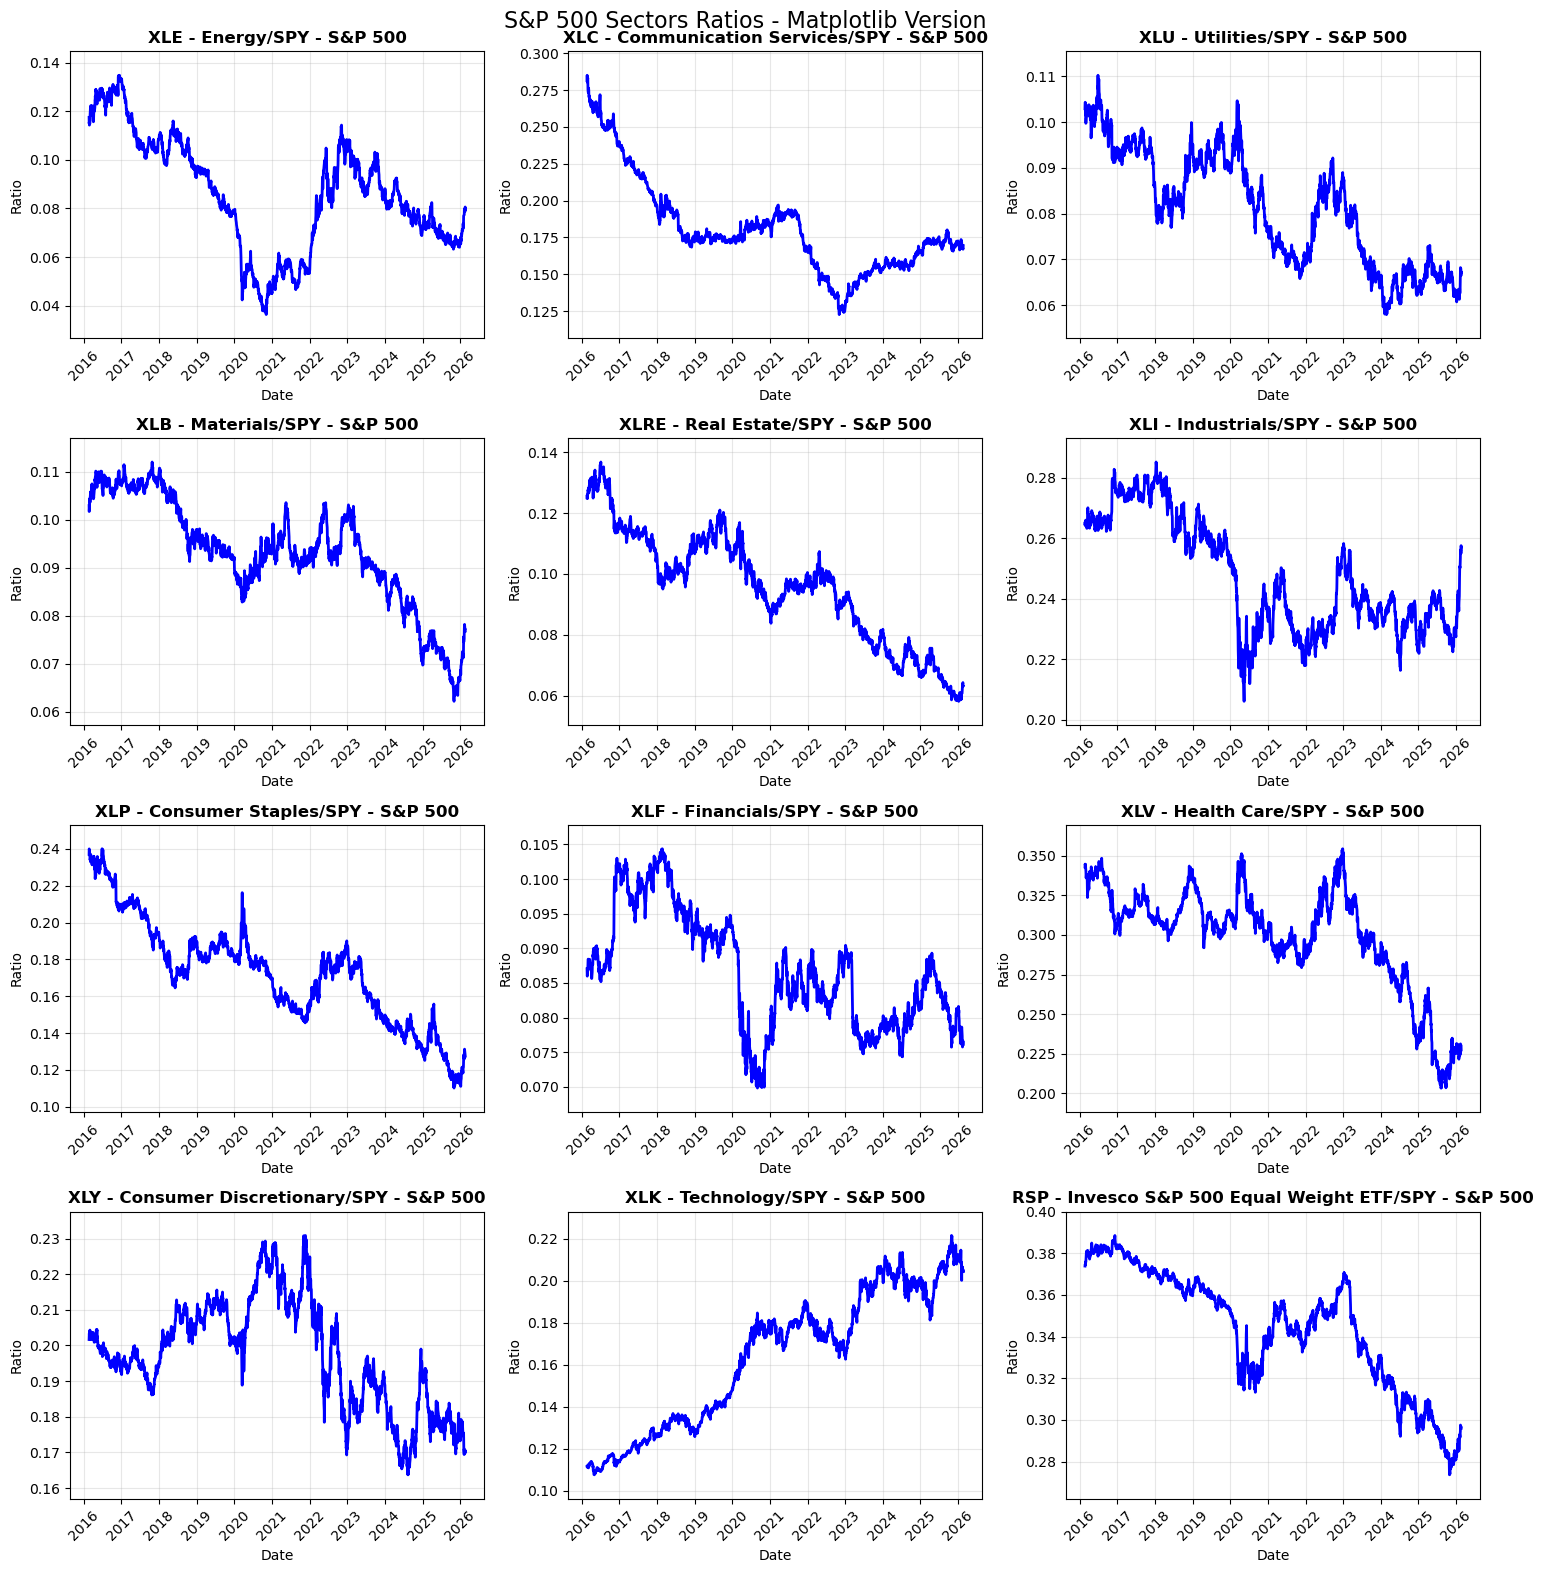


S&P 500 Sectors Ratios Summary Statistics:
XLE - Energy/SPY - S&P 500: Mean=0.0862, Std=0.0235, Min=0.0363, Max=0.1349
XLC - Communication Services/SPY - S&P 500: Mean=0.1810, Std=0.0318, Min=0.1226, Max=0.2851
XLU - Utilities/SPY - S&P 500: Mean=0.0809, Std=0.0125, Min=0.0580, Max=0.1102
XLB - Materials/SPY - S&P 500: Mean=0.0932, Std=0.0113, Min=0.0622, Max=0.1121
XLRE - Real Estate/SPY - S&P 500: Mean=0.0955, Std=0.0186, Min=0.0582, Max=0.1367
XLI - Industrials/SPY - S&P 500: Mean=0.2472, Std=0.0185, Min=0.2062, Max=0.2853
XLP - Consumer Staples/SPY - S&P 500: Mean=0.1723, Std=0.0284, Min=0.1102, Max=0.2400
XLF - Financials/SPY - S&P 500: Mean=0.0866, Std=0.0083, Min=0.0698, Max=0.1044
XLV - Health Care/SPY - S&P 500: Mean=0.2991, Std=0.0329, Min=0.2034, Max=0.3544
XLY - Consumer Discretionary/SPY - S&P 500: Mean=0.1973, Std=0.0151, Min=0.1637, Max=0.2309
XLK - Technology/SPY - S&P 500: Mean=0.1634, Std=0.0323, Min=0.1075, Max=0.2215
RSP - Invesco S&P 500 Equal Weight ETF/SPY - S&P

In [11]:
# Alternative matplotlib visualization of S&P 500 sectors ratios

# Create subplots using matplotlib
n_ratios = len(ratios_list)
n_cols = 3
n_rows = (n_ratios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle('S&P 500 Sectors Ratios - Matplotlib Version', fontsize=16, y=0.98)

# Flatten axes array for easier indexing
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

# Plot each ratio
for i, ratio in enumerate(ratios_list):
    if i < len(axes):
        axes[i].plot(ratios_df.index, ratios_df[ratio], linewidth=2, color='blue')
        axes[i].set_title(f'{ratio}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Ratio')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Remove zero values from y-axis display for better scaling
        non_zero_data = ratios_df[ratio][ratios_df[ratio] > 0]
        if not non_zero_data.empty:
            y_min, y_max = non_zero_data.min(), non_zero_data.max()
            margin = (y_max - y_min) * 0.1
            axes[i].set_ylim(max(0, y_min - margin), y_max + margin)

# Hide any unused subplots
for i in range(len(ratios_list), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nS&P 500 Sectors Ratios Summary Statistics:")
print("=" * 50)
for ratio in ratios_list:
    non_zero_data = ratios_df[ratio][ratios_df[ratio] > 0]
    if not non_zero_data.empty:
        print(f"{ratio:>10}: Mean={non_zero_data.mean():.4f}, "
              f"Std={non_zero_data.std():.4f}, "
              f"Min={non_zero_data.min():.4f}, "
              f"Max={non_zero_data.max():.4f}")
    else:
        print(f"{ratio:>10}: No valid data available")

In [12]:
# plot ratios for each pair in ratios_df using plotly express
import plotly.express as px

for c in ratios_df.columns:
    fig = px.line(ratios_df, x=ratios_df.index, y=c, title=f'{c} Ratio Over Time')
    fig.update_layout(xaxis_title='Date', yaxis_title='Ratio')
    fig.show()